# 基于SRL的忏悔识别

In [1]:
import spacy
import pandas as pd
import numpy as np
nlp = spacy.load("en_core_web_lg")

In [2]:
sample_df = pd.read_csv("../data/last_words_sampled_rows.csv")
sample_statements = sample_df["last.statement"].tolist()
sample_statements

['I have come here today to die, not make speeches. Today is a good day for dying. My Honor Is My Life.',
 ' Tell Mama I love her.',
 nan,
 'I just want everyone to know that the prosecutor and Bill Scott are sorry sons of bitches. To his family he added that he loved them all.',
 nan,
 nan,
 " I'm innocent. I had nothing to do with my family's murders. I want to thank everyone who has supported me. I hope they continue to fight. You know who you are. That's all. Thank you, Warden.  ",
 "  Yes sir. To Edie, Tom, and and Carma - I love all you all.  I appreciate all your support.  I love you Margherita, Father Guido, and Father Angelo.  I appreciate your spiritual support and all those that were in prayer for me.  I will be O.K.  I am at peace with all of this and I won't have to wake up in prison any more.  I love you all.  I totally surrender to the Lord.  I am ready, Warden. ",
 ' Into your hands Oh Lord, I commence my spirit.  Amen.  ',
 "I would like to apologize to the Nix family 

## 找到文本中的受害者

In [3]:
def is_family_member(sentence, entity):
    """
    Determine if an entity in a sentence is a family member based on contextual clues.
    
    Args:
        sentence (str): The sentence containing the entity
        entity (spacy.tokens.span.Span): The entity to check
        
    Returns:
        bool: True if the entity is likely a family member, False otherwise
    """
    if entity.text == "God":
        return False
    # Family-related terms
    family_terms = [
        "family", "mother", "father", "mom", "dad", "brother", "sister", 
        "son", "daughter", "child", "children", "kids", "wife", "husband", 
        "spouse", "grandma", "grandpa", "grandmother", "grandfather", 
        "aunt", "uncle", "cousin", "niece", "nephew", "parents"
    ]
    
    # Create a spaCy Doc object
    doc = nlp(sentence)
    
    # Find the entity in the sentence
    entity_tokens = []
    entity_text = entity.text.lower()
    for token in doc:
        if token.text.lower() == entity_text:
            entity_tokens.append(token)
    
    if not entity_tokens:
        return False
    
    # Check if the entity is explicitly referred to as a family member
    for token in entity_tokens:
        # Look at a window of 5 tokens around the entity
        start = max(0, token.i - 5)
        end = min(len(doc), token.i + 6)
        window = doc[start:end]
        
        # Check if there are family terms in the window
        for w in window:
            if w.text.lower() in family_terms:
                return True
        
        # Check for possessive patterns like "my [entity]" or "[entity] is my..."
        for i, w in enumerate(window):
            if i < len(window) - 1 and w.text.lower() == "my" and window[i+1].text.lower() == entity_text:
                return True
                
        # Check for relationship indicators
        for w in window:
            if w.dep_ == "poss" and w.text.lower() in ["my", "our"]:
                return True
    
    return False

In [4]:
sample_statements[11]

"Tell my son I love him very much. God bless everybody. Continue to walk with God. Go Cowboys! Love ya'll man. Don't forget the T-ball. Ms. Mary, thank you for everything that you've done. You too, Brad, thank you. I can feel it, taste it, not bad."

In [5]:
appologize_tokens = [
    'sorry',
    'apologize',
    'forgive',
    'regret',
    'remorse',
]
def regret_dector(statement):
    """
    This function takes a statement and returns 1 if it contains any of the words
    'sorry', 'apologize', 'regret', or 'forgive'. Otherwise, it returns 0.
    """
    doc = nlp(statement)
    # 对doc进行分句
    sentences = list(doc.sents)
    for sentence in sentences:
        # 首先，道歉的主语应当是自己，而不是他人
        sen = nlp(sentence.text)
        # 检查道歉的主语是否是自己
        if not any(token.text.lower() in ["i", "me", "myself"] for token in sen if token.dep_ == "nsubj"):
            continue
        # 检查道歉的谓语是否为自己的家人，如果是，则跳过此循环
        if any(token.text.lower() in ["family", "kids", "children", "mom", "dad", "parents"] for token in sen if token.dep_ == "dobj"):
            continue
        # 最后，检查是否存在道歉行为，首先，看是否有道歉的相关谓词
        for token in sen:
            if token.lemma_ in appologize_tokens:
                return 1
        # 检查句子中是否有承担责任的表达, 如果有，也返回1
        if any(token.text.lower() in ["responsibility", "accountable", "blame"] for token in sen):
            return 1
    return 0


In [6]:
appologize_tokens = [ # 这个列表可以保留用于参考或其他用途
    'sorry',
    'apologize',
    'forgive',
    'regret',
    'remorse',
]

def regret_dector(statement):
    """
    这个函数接受一个陈述并返回1如果它表明说话者有悔恨情绪。
    否则返回0。
    """
    if not isinstance(statement, str) or not statement.strip():
        return 0
        
    doc = nlp(statement)
    sentences = list(doc.sents)

    for sentence_span in sentences: # 直接使用Span对象

        # 过滤器1：句子必须包含"I"、"me"或"myself"作为主语。
        # 这有助于专注于说话者自己的悔恨陈述。
        if not any(token.text.lower() in ["i", "me", "myself"] for token in sentence_span if token.dep_ == "nsubj"):
            continue

        # 过滤器2：道歉不是（仅仅）针对说话者自己家庭的困难。
        # 这是原始代码中的一个细致过滤器。
        # 它检查直接宾语是否为家庭成员术语。
        # 这可能需要根据具体要求进一步完善。
        if any(token.text.lower() in ["family", "kids", "children", "mom", "dad", "parents"] for token in sentence_span if token.dep_ == "dobj"):
            continue

        # 检查道歉/悔恨表达
        for token in sentence_span:
            token_lemma = token.lemma_.lower()
            token_text = token.text.lower()

            # --- 处理"sorry" ---
            if token_lemma == 'sorry':
                is_regretful_sorry = False
                # 情况1："I am sorry"、"I feel sorry"
                # 'sorry'是形容词补语(acomp)或属性(attr)
                # 动词/助动词的主语是"I"。
                if token.dep_ in ['acomp', 'attr'] and token.head.pos_ in ['VERB', 'AUX']:
                    verb_head = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in verb_head.children):
                        is_regretful_sorry = True
                # 情况2："Sorry, ..."（感叹词）
                elif token.pos_ == 'INTJ':
                    is_regretful_sorry = True
                # 情况3："Sorry about that."（'sorry'作为句子的根且是形容词）
                elif token.dep_ == 'ROOT' and token.pos_ == 'ADJ':
                    is_regretful_sorry = True
                
                if is_regretful_sorry:
                    return 1
                # 如果'sorry'是形容词修饰语(amod)，如"sorry sons of bitches"中的用法，
                # 它不会匹配上述条件，也不会被计为悔恨。

            # --- 处理道歉动词（apologize、forgive、regret）---
            elif token_lemma in ['apologize', 'forgive', 'regret'] and token.pos_ == 'VERB':
                verb_is_by_speaker = False
                # 检查"I"是否是这个动词的直接主语
                if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in token.children):
                    verb_is_by_speaker = True
                # 检查像"I want to apologize"这样的模式（动词是xcomp，主动词的主语是"I"）
                elif token.dep_ == 'xcomp' and token.head.pos_ in ['VERB', 'AUX']:
                    main_verb = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in main_verb.children):
                        verb_is_by_speaker = True
                
                if verb_is_by_speaker:
                    return 1

            # --- 处理道歉名词（remorse、regret）---
            elif token_lemma in ['remorse', 'regret'] and token.pos_ == 'NOUN':
                noun_is_by_speaker = False
                # 检查"I have/feel remorse/regret"（名词是动词的直接宾语，动词的主语是"I"）
                if token.dep_ == 'dobj' and token.head.pos_ in ['VERB', 'AUX']:
                    verb_head = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in verb_head.children):
                        noun_is_by_speaker = True
                # 检查"my remorse/regret"（名词是主语或宾语，被"my"所拥有）
                elif any(child.dep_ == 'poss' and child.text.lower() == 'my' for child in token.children):
                    noun_is_by_speaker = True

                if noun_is_by_speaker:
                    return 1

        # 检查承担责任（与"I"相关）
        for token in sentence_span:
            token_text = token.text.lower()
            # "I take/accept responsibility"
            if token_text == "responsibility" and token.dep_ == 'dobj' and \
               token.head.pos_ == 'VERB' and token.head.lemma_ in ['take', 'accept', 'assume']:
                action_verb = token.head
                if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in action_verb.children):
                    return 1
            # "I am accountable"
            elif token_text == "accountable" and token.dep_ in ['acomp', 'attr'] and \
                 token.head.pos_ in ['VERB', 'AUX']:
                copula_verb = token.head
                if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in copula_verb.children):
                    return 1
            # "I take the blame"或"I blame myself"
            elif token_text == "blame":
                # "I take/accept the blame"（blame作为名词）
                if token.pos_ == 'NOUN' and token.dep_ == 'dobj' and \
                   token.head.pos_ == 'VERB' and token.head.lemma_ in ['take', 'accept', 'assume']:
                    action_verb = token.head
                    if any(child.dep_ == 'nsubj' and child.text.lower() in ["i", "me", "myself"] for child in action_verb.children):
                        return 1
                # "I blame myself"（blame作为动词）
                elif token.pos_ == 'VERB' and token.lemma_ == 'blame':
                    subj_is_i = any(child.dep_ == 'nsubj' and child.text.lower() == 'i' for child in token.children)
                    dobj_is_myself = any(child.dep_ == 'dobj' and child.text.lower() == 'myself' for child in token.children)
                    if subj_is_i and dobj_is_myself:
                        return 1
    return 0

In [7]:
df = pd.read_csv("../data/raw_last_statement.csv")
df.head()

,execution,length,last_statement
0,593,219.0,There is not a day that goes by that I don't r...
1,592,54.0,"I will always love you no matter, that our lov..."
2,591,168.0,"Yes ma'am, first I would like to apologize for..."
3,590,142.0,"Yes Warden, I would like to thank everyone, al..."
4,589,78.0,Yes. I want to say thank you to all the people...


In [8]:
df['nlp_sentence'] = df['last_statement'].apply(lambda x: regret_dector(str(x)))

In [9]:
df.head()

,execution,length,last_statement,nlp_sentence
0,593,219.0,There is not a day that goes by that I don't r...,1
1,592,54.0,"I will always love you no matter, that our lov...",0
2,591,168.0,"Yes ma'am, first I would like to apologize for...",1
3,590,142.0,"Yes Warden, I would like to thank everyone, al...",1
4,589,78.0,Yes. I want to say thank you to all the people...,1


In [10]:
sample_df = pd.read_csv("../data/last_words_sampled_rows.csv")
def to_bin(x):
    return 1 if x >= 0.8 else 0
sample_df['label-penitence'] = sample_df['label-penitence'].apply(lambda x: to_bin(x))
sample_df.head()

,Unnamed: 0,execution,length,last.statement,label-penitence,label-opion-on-capital-punishment
0,415,157,22,"I have come here today to die, not make speech...",0,0.5
1,463,109,5,Tell Mama I love her.,0,0.5
2,179,393,0,NaN,0,0.5
3,526,46,27,I just want everyone to know that the prosecut...,0,0.5
4,195,377,0,NaN,0,0.5


In [11]:
test_df = pd.merge(sample_df, df[['execution', 'nlp_sentence']], on='execution', how='left')
test_df.head(20)

,Unnamed: 0,execution,length,last.statement,label-penitence,label-opion-on-capital-punishment,nlp_sentence
0,415,157,22,"I have come here today to die, not make speech...",0,0.5,0
1,463,109,5,Tell Mama I love her.,0,0.5,0
2,179,393,0,NaN,0,0.5,0
3,526,46,27,I just want everyone to know that the prosecut...,0,0.5,0
4,195,377,0,NaN,0,0.5,0
5,118,454,0,NaN,0,0.5,0
6,299,273,36,I'm innocent. I had nothing to do with my fam...,0,0.0,0
7,229,343,79,"Yes sir. To Edie, Tom, and and Carma - I lov...",0,0.5,0
8,244,328,10,"Into your hands Oh Lord, I commence my spirit...",0,0.5,0
9,14,580,35,I would like to apologize to the Nix family fo...,1,1.0,1


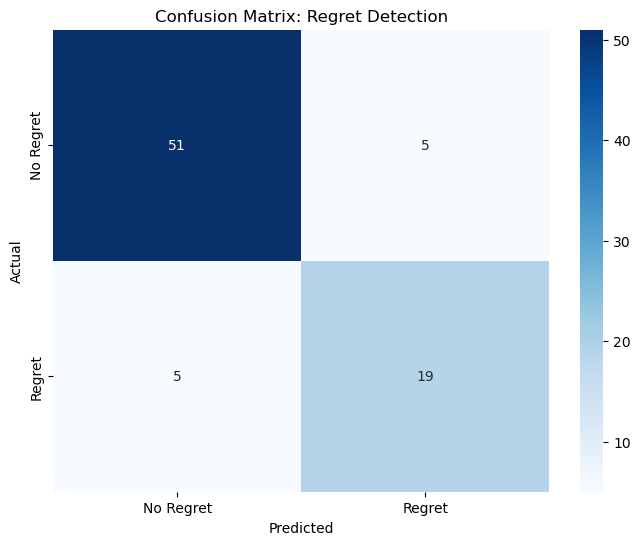

Confusion Matrix:
[[51  5]
 [ 5 19]]

True Negatives: 51
False Positives: 5
False Negatives: 5
True Positives: 19


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

import matplotlib.pyplot as plt

# Create confusion matrix
cm = confusion_matrix(test_df['label-penitence'], test_df['nlp_sentence'])

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['No Regret', 'Regret'], 
            yticklabels=['No Regret', 'Regret'])
plt.title('Confusion Matrix: Regret Detection')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.savefig('../visualize/confusion_matrix_regret_detection.png', dpi=600)
plt.show()

# Print confusion matrix details
print("Confusion Matrix:")
print(cm)
print(f"\nTrue Negatives: {cm[0,0]}")
print(f"False Positives: {cm[0,1]}")
print(f"False Negatives: {cm[1,0]}")
print(f"True Positives: {cm[1,1]}")

In [13]:
print(70/80)

0.875


In [14]:
test_df.loc[12]['last.statement']

" Kathy, y'all take and I bless all of you and I am glad I have had y'all in my life. As I have said from the very first thing, I am innocent of this crime and God knows I am innocent and the four people that was murdered know I am innocent and when I get to heaven I'll be hunting you and we'll talk. I feel sorry for the families that's had to suffer and my family and I have 'em all in my prayers. I love you all. Y'all take and y'all look after Sheila and Shannon and them, call 'em and get the pictures to 'em and everything and, ah, again, like I said, I feel sorry for the families, but if it takes my death to make them happy, then I will bless them. I have no hard feelings toward anyone cause the Lord feels that it is my time to come home to Him, my work on earth is done and that, ah, like I said, I am just sorry for, but they will have to go through this one time again, cause sooner or later, whoever did this crime is going to be caught and they'll have to come down here and do this 

In [15]:
regret_dector(test_df.loc[3]['last.statement'])

0

# 对死刑遗言的最终分析

In [16]:
df['nlp_score'] = df['last_statement'].apply(lambda x: regret_dector(str(x)))

In [17]:
df['nlp_score'].value_counts()

nlp_score
0    395
1    176
Name: count, dtype: int64

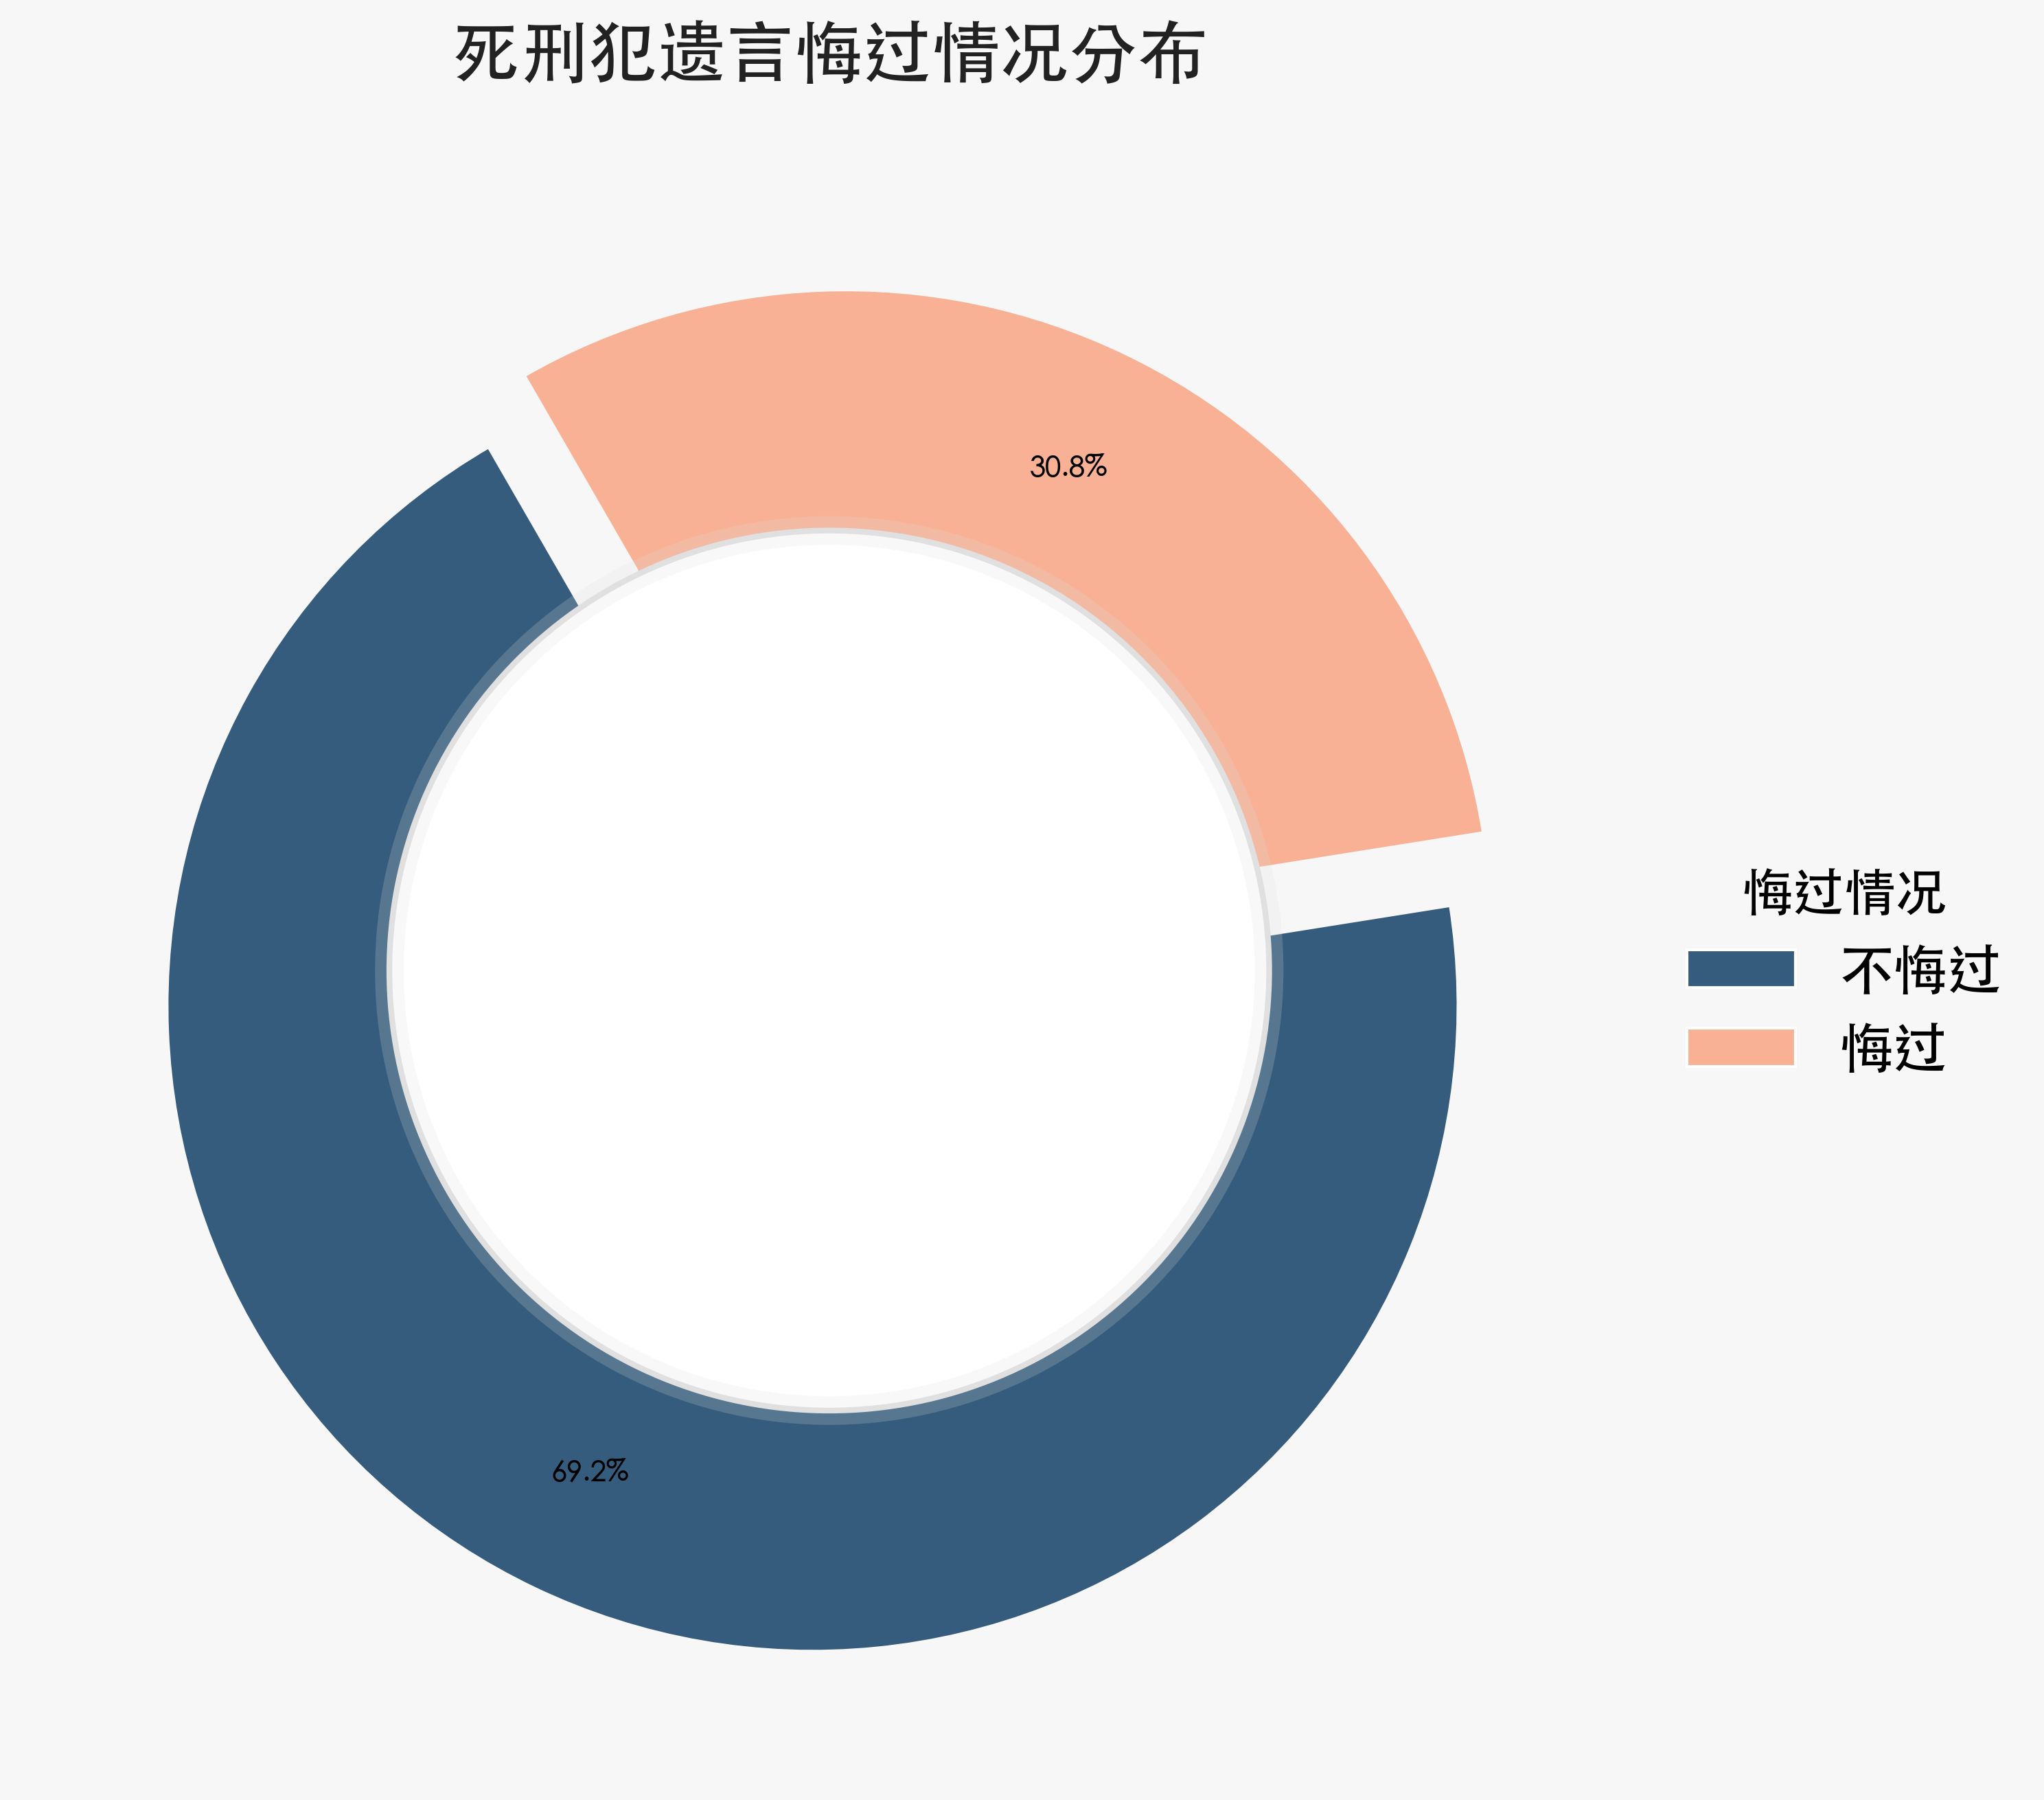


悔过情况统计:
nlp_sentence
不悔过    395
悔过     176
Name: count, dtype: int64


In [18]:
# 替换标签
df['nlp_sentence'] = df['nlp_score'].map({1: '悔过', 0: '不悔过'})

# 设置中文字体 - 使用更清晰的字体
plt.rcParams['font.family'] = 'Heiti TC'  # 替换为你选择的字体

import matplotlib.pyplot as plt
import numpy as np

# 统计数据
value_counts = df['nlp_sentence'].value_counts()
labels = value_counts.index
sizes = value_counts.values

# 高级配色（可自定义）
colors = ['#355C7D', '#F8B195', '#6C5B7B', '#F67280', '#C06C84', '#355C7D'][:len(labels)]

# 爆炸效果
explode = [0.06] * len(labels)

# 设置更大的图形尺寸和更高的DPI
fig, ax = plt.subplots(figsize=(10, 10), facecolor='#f7f7f7', dpi=300)

# 绘制饼图
wedges, texts, autotexts = ax.pie(
    sizes,
    labels=None,
    autopct='%1.1f%%',
    colors=colors,
    explode=explode,
    startangle=120,
    pctdistance=0.8,
    shadow=False,
    wedgeprops={'linewidth': 2, 'edgecolor': '#f7f7f7'}
)

# 添加圆环效果
centre_circle = plt.Circle((0, 0), 0.68, fc='white', linewidth=2, edgecolor='#e0e0e0', zorder=10)
ax.add_artist(centre_circle)

# 内阴影
inner_shadow = plt.Circle((0, 0), 0.68, fc='none', linewidth=10, edgecolor='#e0e0e0', alpha=0.2, zorder=11)
ax.add_artist(inner_shadow)

# 百分比+标签+数量分行显示 - 增大字体
total = sum(sizes)
for i, (wedge, size, label) in enumerate(zip(wedges, sizes, labels)):
    ang = (wedge.theta2 + wedge.theta1) / 2.
    x = np.cos(np.deg2rad(ang)) * 0.92
    y = np.sin(np.deg2rad(ang)) * 0.92

# 美化标题 - 增大字体
plt.title('死刑犯遗言悔过情况分布', fontsize=24, fontweight='bold', color='#222222', pad=30)

# 自定义图例 - 增大字体
from matplotlib.patches import Patch
legend_elements = [Patch(facecolor=colors[i], edgecolor='white', label=f"{labels[i]}") for i in range(len(labels))]
plt.legend(
    handles=legend_elements,
    title="悔过情况",
    loc="center left",
    bbox_to_anchor=(1, 0.5),
    fontsize=19,  # 增大字体
    title_fontsize=18,  # 增大标题字体
    frameon=False
)

plt.tight_layout()
plt.ylabel('')
plt.savefig('../visualize/regret_distribution_pie_chart.png', dpi=600, bbox_inches='tight')
plt.show()

# 打印具体数值
print("\n悔过情况统计:")
print(value_counts)

In [19]:
dt = pd.read_excel('../data/final_data_setv1.xlsx')

In [20]:
dt.head()

,execution,offender_information_url,last_statement_url,last_name,first_name,TDCJ_Number,age,date,race,gender,...,county,prior occupation,prior prison record(0/1),prior prison record,Co-Defendants,Summary,Race and Gender of Victim,last statement 0/1,length,last statement
0,593,https://www.tdcj.texas.gov/death_row/dr_info/t...,NaN,Tabler,Richard,999523,46,02/13/2025,White,male,...,Bell,"Construction, Cook",1,California Dept. of Corrections on a 3 year se...,Information not available at this time.,"On November 26, 2004 in Bell County, Tabler an...",Other male,1.0,219.0,There is not a day that goes by that I don't r...
1,592,https://www.tdcj.texas.gov/death_row/dr_info/n...,NaN,Nelson,Steven,999576,37,02/05/2025,Black,male,...,Tarrant,Laborer,1,"#1440381 - State jail offense for Theft, disch...",Anthony Gregory Springs and Clifford Jefferson,Subject and two codefendants entered the churc...,White male,1.0,54.0,"I will always love you no matter, that our lov..."
2,591,https://www.tdcj.texas.govdr_info/whitegarcia.jpg,NaN,White,Garcia,999205,61,10/1/2024,Black,male,...,Harris,fry cook,0,NaN,none,Convicted in the December 1989 stabbing deaths...,two black females,1.0,168.0,"Yes ma'am, first I would like to apologize for..."
3,590,https://www.tdcj.texas.govdr_info/mullistravis...,NaN,Mullis,Travis,999563,38,9/24/2024,White,male,...,Galveston,General Laborer,0,NaN,none,"In Galveston County TX, the subject stomped o...",White male,1.0,142.0,"Yes Warden, I would like to thank everyone, al..."
4,589,https://www.tdcj.texas.govdr_info/burtonarthur...,NaN,Burton,Arthur,999283,44,8/7/2024,Black,male,...,Harris,unknown,0,NaN,NaN,"On July 29, 1997, in Houston, Texas, Burton c...",White female,1.0,78.0,Yes. I want to say thank you to all the people...


In [21]:
dt['nlp_score'] = dt['last statement'].apply(lambda x: regret_dector(str(x)))
# 替换标签
dt['nlp_sentence'] = dt['nlp_score'].map({1: '悔过', 0: '不悔过'})

In [22]:
dt['gender'].value_counts()

gender
male      551
female      6
ma1e        3
Name: count, dtype: int64

In [38]:
# 定义年龄分箱的边界 - 青年(<30)、中年(30-55)、老年(>55)
age_bins = [0, 30, 55, 100]
age_labels = ['青年', '中年', '老年']

# 使用pd.cut进行分箱
dt['age_group'] = pd.cut(dt['age'], bins=age_bins, labels=age_labels)

# 将分箱结果转换为数值编码
age_mapping = {
    '青年': 0,
    '中年': 1,
    '老年': 2
}

dt['age_code'] = dt['age_group'].map(age_mapping)

# 显示分箱结果统计
print("年龄分组统计:")
print(dt['age_group'].value_counts().sort_index())

年龄分组统计:
age_group
青年     81
中年    456
老年     34
Name: count, dtype: int64


In [23]:
set(dt['prior occupation'])

{'/carpenter',
 'Architecture Design, Clerical',
 'Builder/Laborer',
 'Bus Boy, Laborer',
 'Construction, Cook',
 'General Laborer',
 'Kitchen Laborer',
 'Laborer',
 'Roofer, Stocker, & Laborer',
 'Steel Fabrication, Cook, Laborer',
 'Truck Driver',
 "Truck Driver, Backhoe Operator, Welder's Helper, Pipe Fitter's Helper.",
 'Truck Driver, Warehouseman.',
 'Truck Driver/Laborer',
 'Warehouse Worker, Laborer',
 'Warehouseman, Carpenter, Laborer',
 'Welder, Fence Builder',
 'Wrecker Driver/General Construction/Lineman/Laborer',
 'accounting',
 'air conditioner repairman',
 'analyst engineer',
 'antique refinisher',
 'apprentice bricklayer',
 'attendant',
 'auto body painter, truck driver, auto mechanic, laborer',
 'auto body repairman',
 'auto mechanic',
 'auto mechanic, laborer',
 'auto repossesser',
 'auto sales',
 'awaiting  information',
 'baker',
 'baker, laborer',
 'barber',
 'barber, cook, laborer',
 'barber, kitchen, laborer',
 'barber, mechanic, laborer',
 'bartender/laborer',
 '

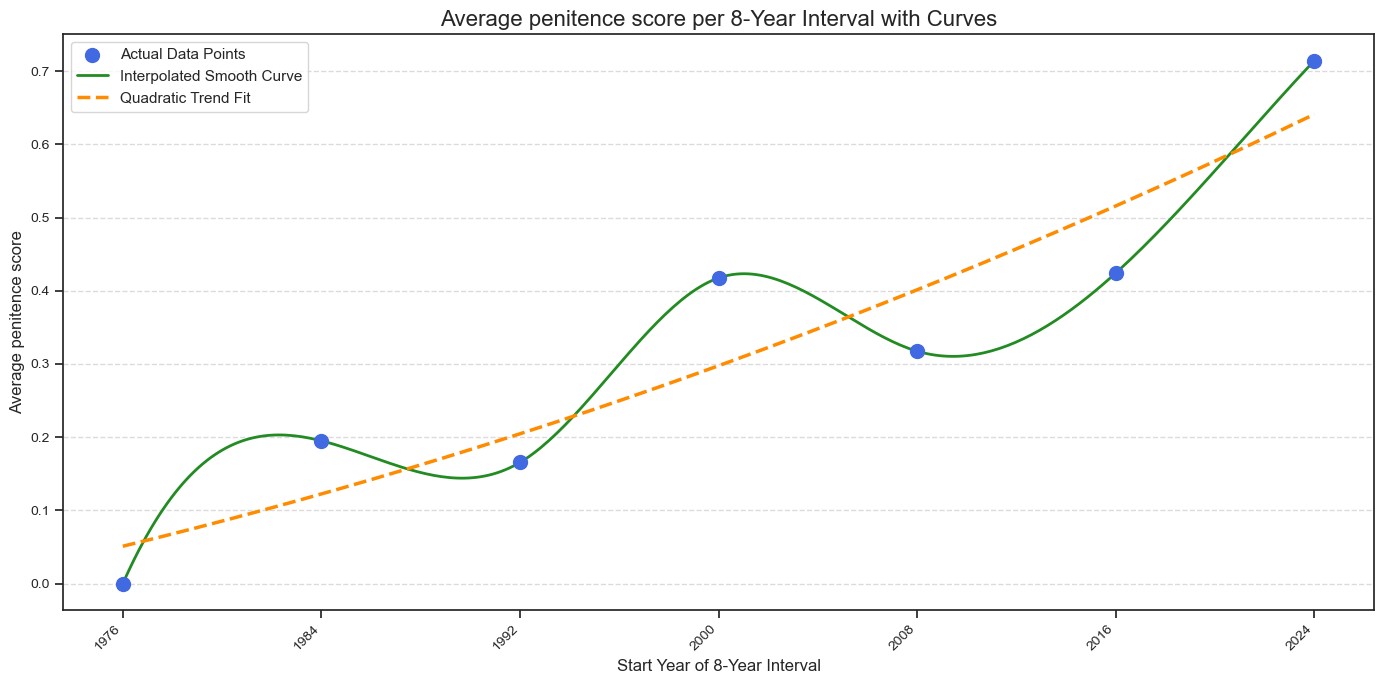

In [68]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.interpolate import make_interp_spline

# 设置Seaborn主题
sns.set_theme(style="ticks", palette="viridis")

# 确保日期格式正确
dt['date'] = pd.to_datetime(dt['date'], errors='coerce')
dt.dropna(subset=['date'], inplace=True)

# 提取年份并创建8年区间
dt['year'] = dt['date'].dt.year
dt['year_bin'] = (dt['year'] // 8) * 8

# 计算每个8年区间的平均nlp score
average_nlp_per_8year = dt.groupby('year_bin')['nlp_score'].mean().reset_index()
average_nlp_per_8year = average_nlp_per_8year.sort_values(by='year_bin')

# --- 准备原始数据点和插值曲线数据 ---
x_data_points = average_nlp_per_8year['year_bin']
y_data_points = average_nlp_per_8year['nlp_score']

# 使用B样条插值创建平滑曲线的密集点
x_smooth = np.linspace(x_data_points.min(), x_data_points.max(), 300)
# 确保 make_interp_spline 的输入 x 是单调递增的
spline = make_interp_spline(x_data_points, y_data_points, k=3)  # k=3表示使用三次样条
y_smooth = spline(x_smooth)

# --- 多项式拟合趋势线 ---
# 使用 numpy.polyfit 进行二次多项式拟合 (degree=2)
# 拟合结果coeffs是多项式的系数，按照降幂排列 (ax^2 + bx + c)
coeffs = np.polyfit(x_data_points, y_data_points, 2)

# 创建一个表示多项式函数的对象
poly = np.poly1d(coeffs)

# 生成用于绘制拟合趋势线的 x 值范围 (可以使用插值曲线的 x_smooth)
x_trend = x_smooth

# 计算拟合趋势线对应的 y 值
y_trend = poly(x_trend)
# --- 拟合部分结束 ---


# 绘制图表
plt.figure(figsize=(14, 7))

# 绘制原始数据点
plt.scatter(x_data_points, y_data_points, color='royalblue', s=100, label='Actual Data Points', zorder=3)

# 绘制B样条插值平滑曲线 (根据你之前的代码保留)
plt.plot(x_smooth, y_smooth, color='forestgreen', linewidth=2, label='Interpolated Smooth Curve', zorder=2) # 修改颜色以区分

# --- 绘制多项式拟合趋势线 (虚线) ---
plt.plot(x_trend, y_trend, color='darkorange', linestyle='--', linewidth=2.5, label='Quadratic Trend Fit', zorder=4) # 使用虚线和不同颜色
# --- 绘制拟合趋势线结束 ---


# 设置标题和标签
plt.title('Average penitence score per 8-Year Interval with Curves', fontsize=16) # 修改标题以反映多条线
plt.xlabel('Start Year of 8-Year Interval', fontsize=12)
plt.ylabel('Average penitence score', fontsize=12)

# 优化刻度标签
# 使用原始数据点的x值作为刻度位置
plt.xticks(x_data_points, rotation=45, ha='right', fontsize=10)
plt.yticks(fontsize=10)

# 添加网格线
plt.grid(axis='y', linestyle='--', alpha=0.7)

# 添加图例
plt.legend()

# 调整布局
plt.tight_layout()
plt.savefig('../visualize/average_nlp_score_per_8year_interval_with_curves.png', dpi=600, bbox_inches='tight')
plt.show()

In [24]:
import pandas as pd
import numpy as np

# 假设你的DataFrame叫做 dt，职业列是 'prior occupation'
# 如果你的DataFrame是其他名字，请替换这里的 dt

# 定义高档和低档职业的关键词列表
# 你可以根据需要调整这些列表
high_class_keywords = [
    'architecture design', 'analyst engineer', 'computer', 'custom furniture builder',
    'diesel mechanic', 'electrician', 'general contractor', 'hair stylist',
    'heavy equipment operator', 'insurance investor', 'iron worker',
    'machine operator', 'master mechanic', 'millwright', 'musician',
    'occupational therapist', 'office worker', 'plumber', 'press operator',
    'produce broker', 'public safety officer', 'radiator repair',
    'retail merchant', 'salesman', 'sculptor', 'stockbroker',
    'telephone cable installer', 'truck driver', 'welder', 'carpenter'
]

low_class_keywords = [
    'laborer', 'bus boy', 'cook', 'dishwasher', 'farm hand', 'fast food',
    'gardener', 'janitor', 'mover', 'nurse\'s aide', 'restaurant worker',
    'roofer', 'roughneck', 'shrimper', 'student', 'tankerman',
    'telemarketing', 'unemployed', 'unknown', 'waiter', 'warehouse worker'
]

# 创建判断职业类别的函数
def categorize_occupation(occupation):
    if pd.isna(occupation) or occupation.strip() == '' or occupation.strip() == '\xa0':
        return 'unknown' # 处理缺失值或空字符串

    # 转换为小写以便匹配
    occupation_lower = str(occupation).lower()

    # 检查是否包含低档职业关键词 (优先判断低档，因为一些复合职业包含 laborer)
    for keyword in low_class_keywords:
        if keyword in occupation_lower:
            return 'low-class'

    # 检查是否包含高档职业关键词
    for keyword in high_class_keywords:
        if keyword in occupation_lower:
            return 'high-class'

    # 如果没有匹配到已知关键词，可以归为unknown或low-class，这里设为unknown
    return 'unknown'

# 应用函数到 'prior occupation' 列
dt['occupation_category'] = dt['prior occupation'].apply(categorize_occupation)

# 将类别转换为数值编码 (例如: high-class=1, low-class=0, unknown=-1 或保留)
# 这里我们将 high-class 编码为 1， low-class 编码为 0， unknown 保留
occupation_mapping = {
    'high-class': 1,
    'low-class': 0,
    'unknown': 0 # 或者给一个特定数值，比如 -1
}

dt['occupation_encoded'] = dt['occupation_category'].map(occupation_mapping)

# 显示结果
print(dt[['prior occupation', 'occupation_category', 'occupation_encoded']])

       prior occupation occupation_category  occupation_encoded
0    Construction, Cook           low-class                   0
1               Laborer           low-class                   0
2              fry cook           low-class                   0
3       General Laborer           low-class                   0
4               unknown           low-class                   0
..                  ...                 ...                 ...
566             unknown           low-class                   0
567             unknown           low-class                   0
568             unknown           low-class                   0
569             laborer           low-class                   0
570             laborer           low-class                   0

[571 rows x 3 columns]


In [25]:
# 将gender转换为二值变量 (0表示女性，1表示男性)
dt['gender'] = dt['gender'].map({'female': 0, 'male': 1})

In [26]:
# 将race转换为数值型变量
race_mapping = {
    'Black': 0,
    'Hispanic': 1,
    'Other': 2,
    'White': 3
}
dt['race'] = dt['race'].map(race_mapping)


/opt/anaconda3/envs/machine_learning/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/envs/machine_learning/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 20851 (\N{CJK UNIFIED IDEOGRAPH-5173}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/envs/machine_learning/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 31995 (\N{CJK UNIFIED IDEOGRAPH-7CFB}) missing from font(s) Arial.
  fig.canvas.draw()
/opt/anaconda3/envs/machine_learning/lib/python3.12/site-packages/seaborn/utils.py:61: UserWarning: Glyph 25968 (\N{CJK UNIFIED IDEOGRAPH-6570}) missing from font(s) Arial.
  fig.canvas.draw()
/var/folders/0m/2sbyxxc10czg8dp3clzyzxym0000gn/T/ipykernel_5541/4130172578.py:41: UserWarning: Glyph 30456 (\N{CJK UNIFIED IDEOGRAPH-76F8}) missing from font(s) Arial.
  plt.savefig('../visualize/nlp_correlation_heatmap_age_prio

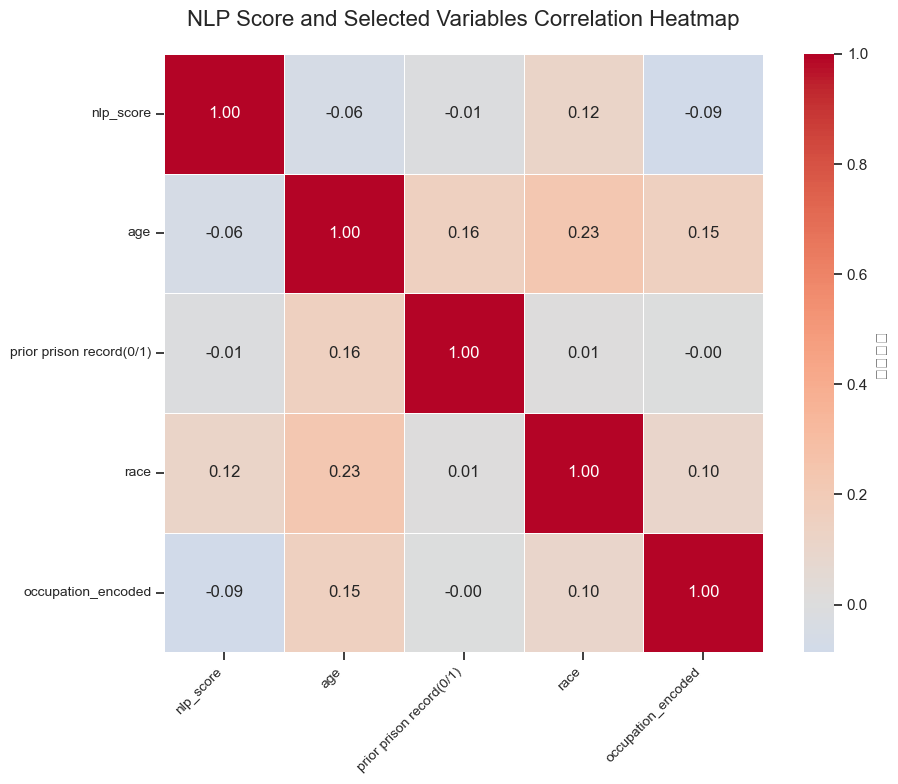


相关性矩阵:
                          nlp_score       age  prior prison record(0/1)  \
nlp_score                  1.000000 -0.056151                 -0.006877   
age                       -0.056151  1.000000                  0.158301   
prior prison record(0/1)  -0.006877  0.158301                  1.000000   
race                       0.116464  0.228617                  0.009217   
occupation_encoded        -0.086908  0.154421                 -0.001810   

                              race  occupation_encoded  
nlp_score                 0.116464           -0.086908  
age                       0.228617            0.154421  
prior prison record(0/1)  0.009217           -0.001810  
race                      1.000000            0.101398  
occupation_encoded        0.101398            1.000000  


In [69]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 选择要计算相关性的列，包括 'age'
columns_to_correlate = ['nlp_score', 'age', 'prior prison record(0/1)', 'race', 'occupation_encoded']

# 计算相关性矩阵
# 确保选中的列存在于 DataFrame 'dt' 中
try:
    correlation_matrix = dt[columns_to_correlate].corr()
except KeyError as e:
    print(f"Error: Column {e} not found in DataFrame.")
    # 如果列不存在，你可能需要检查你的 DataFrame `dt` 是否包含这些列，
    # 或者在计算前进行必要的处理（如确保 'age' 是数值类型）
    # 这里为了演示，我们假设这些列都存在且是数值类型
    # 如果实际运行时报错，请检查数据准备部分
    correlation_matrix = None


# 创建热力图
if correlation_matrix is not None:
    plt.figure(figsize=(10, 8)) # 调整图表尺寸以适应更多的变量
    sns.heatmap(correlation_matrix,
                annot=True,  # 显示具体数值
                cmap='coolwarm',  # 使用蓝红色系
                center=0,  # 将颜色中心设为0
                fmt='.2f',  # 数值保留2位小数
                square=True,  # 保持正方形
                linewidths=.5, # 增加线条分隔
                cbar_kws={'label': '相关系数'})

    # 设置标题和标签
    plt.title('NLP Score and Selected Variables Correlation Heatmap', fontsize=16, pad=20)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(rotation=0, fontsize=10)

    # 调整布局并保存
    plt.tight_layout()
    plt.savefig('../visualize/nlp_correlation_heatmap_age_prior_race_occupation.png', dpi=300, bbox_inches='tight') # 修改保存文件名
    plt.show()

    # 打印相关性矩阵
    print("\n相关性矩阵:")
    print(correlation_matrix)

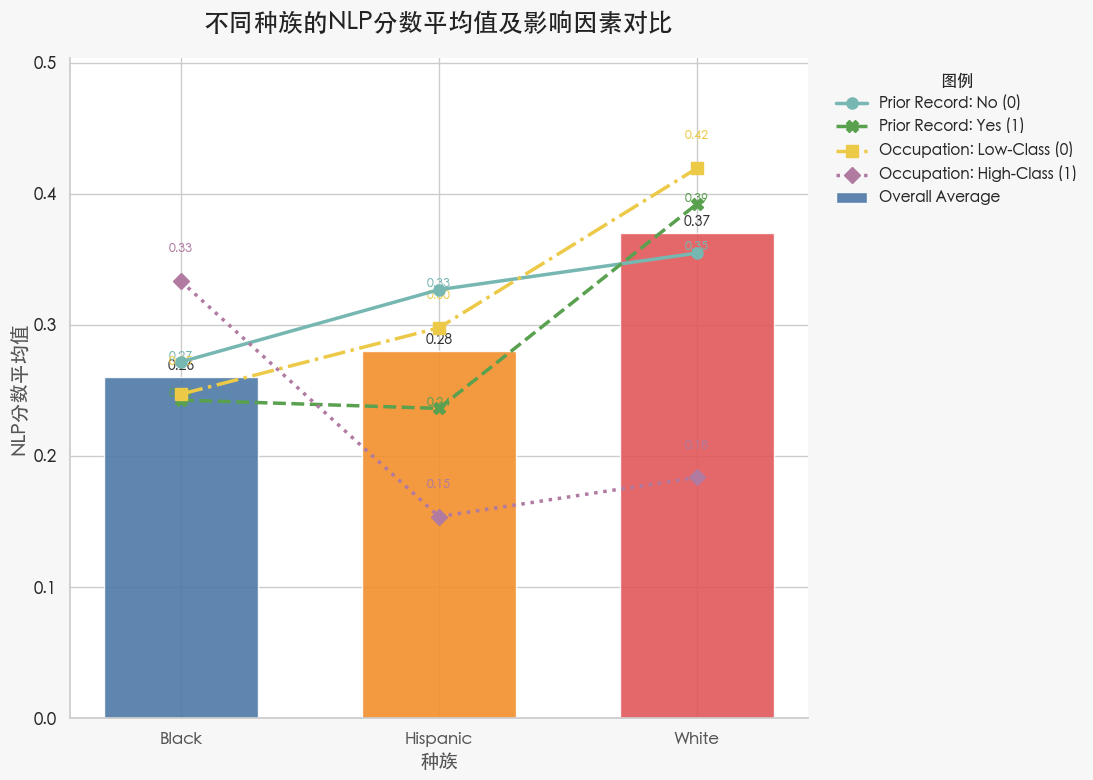


不同种族的NLP分数平均值 (总体):
race
0    0.26
1    0.28
3    0.37
Name: nlp_score, dtype: float64

不同种族和前科情况下的NLP分数平均值:
prior prison record(0/1)         0         1
race                                        
0                         0.271845  0.242718
1                         0.326923  0.236364
3                         0.354839  0.392308

不同种族和职业类别情况下的NLP分数平均值:
occupation_encoded         0         1
race                                  
0                   0.247253  0.333333
1                   0.297872  0.153846
3                   0.419512  0.183673


In [41]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd # 确保 pandas 导入

# 设置seaborn主题和调色板
sns.set_theme(style="whitegrid", font_scale=1.1)
plt.rcParams['font.family'] = 'Heiti TC' # 确保中文显示

# --- Bar Chart Data Calculation ---
# Calculate average nlp_score for different races (excluding Other category)
# Ensure race_means index is 0, 1, 3, and order is Black, Hispanic, White corresponding averages
# Assumes dt DataFrame and 'race' and 'nlp_score' columns exist
race_means = dt[dt['race'].isin([0, 1, 3])].groupby('race')['nlp_score'].mean().round(2)

# Ensure race_labels order matches race_means index order
ordered_race_labels = []
race_label_map = {0: 'Black', 1: 'Hispanic', 3: 'White'}
for idx in race_means.index:
     ordered_race_labels.append(race_label_map.get(idx, f'Race {idx}'))

# --- Line Chart (Prior Record) Data Calculation ---
# Calculate average nlp_score grouped by race and prior prison record
# Assumes 'prior prison record(0/1)' column exists and has values 0 and 1
line_data_prior_record = dt[
    (dt['race'].isin([0, 1, 3])) &
    (dt['prior prison record(0/1)'].isin([0, 1]))
].groupby(['race', 'prior prison record(0/1)'])['nlp_score'].mean().unstack()

# Ensure line data points order matches bar chart x-axis label order
line_data_prior_record = line_data_prior_record.reindex(race_means.index)

# --- New Line Chart (Occupation) Data Calculation ---
# Calculate average nlp_score grouped by race and occupation_encoded
# Assumes 'occupation_encoded' column exists and has values 0, 1 (or NaN)
line_data_occupation = dt[
    (dt['race'].isin([0, 1, 3])) &
    (dt['occupation_encoded'].isin([0, 1])) # Only include 0 and 1 for lines
].groupby(['race', 'occupation_encoded'])['nlp_score'].mean().unstack()

# Ensure line data points order matches bar chart x-axis label order
line_data_occupation = line_data_occupation.reindex(race_means.index)


# --- Chart Drawing ---
# Create chart with a light background
fig, ax = plt.subplots(figsize=(14, 8), facecolor='#f7f7f7') # 适当增大图尺寸

# Use a sophisticated color palette for bars
bar_colors = ['#4E79A7', '#F28E2B', '#E15759']

# Use distinct color palettes for the two sets of lines
prior_record_colors = ['#76B7B2', '#59A14F'] # 例如： tealish, greenish
occupation_colors = ['#EDC948', '#B07AA1'] # 例如： yellow-ish, purplish

# Draw bar chart
x_positions = np.array(range(len(race_means))) # Use numpy array for potential offsets

bars = ax.bar(
    x_positions,
    race_means.values,
    color=bar_colors,
    alpha=0.9,
    width=0.6,
    label='Overall Average'
)

# Display specific values above bars
for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.01 * race_means.max(),
             f'{height:.2f}',
             ha='center', va='bottom',
             fontsize=10, color='#333333', fontweight='semibold')

# Draw Prior Record lines
if 0 in line_data_prior_record.columns:
    ax.plot(
        x_positions,
        line_data_prior_record[0],
        marker='o',
        linestyle='-',
        color=prior_record_colors[0],
        linewidth=2.5,
        markersize=8,
        label='Prior Record: No (0)',
        zorder=5
    )
    for i, txt in enumerate(line_data_prior_record[0]):
        ax.text(
            x_positions[i],
            txt,
            f'{txt:.2f}',
            ha='center', va='bottom',
            fontsize=9,
            color=prior_record_colors[0],
            fontweight='semibold'
        )

if 1 in line_data_prior_record.columns:
    ax.plot(
        x_positions,
        line_data_prior_record[1],
        marker='X',
        linestyle='--',
        color=prior_record_colors[1],
        linewidth=2.5,
        markersize=8,
        label='Prior Record: Yes (1)',
        zorder=5
    )
    for i, txt in enumerate(line_data_prior_record[1]):
         ax.text(
            x_positions[i],
            txt,
            f'{txt:.2f}',
            ha='center', va='bottom',
            fontsize=9,
            color=prior_record_colors[1],
            fontweight='semibold'
        )

# Draw Occupation lines
# Offset x positions slightly for clarity if needed, but keeping aligned might be better here
# x_positions_offset = x_positions + 0.1 # Example offset

if 0 in line_data_occupation.columns:
    ax.plot(
        x_positions, # Or x_positions_offset for first line
        line_data_occupation[0],
        marker='s', # Different marker (square)
        linestyle='-.', # Different linestyle (dash-dot)
        color=occupation_colors[0],
        linewidth=2.5,
        markersize=8,
        label='Occupation: Low-Class (0)',
        zorder=5
    )
    for i, txt in enumerate(line_data_occupation[0]):
         ax.text(
            x_positions[i], # Or x_positions_offset[i]
            txt + 0.02, # Slightly higher text for distinction
            f'{txt:.2f}',
            ha='center', va='bottom',
            fontsize=9,
            color=occupation_colors[0],
            fontweight='semibold'
        )


if 1 in line_data_occupation.columns:
    ax.plot(
        x_positions, # Or x_positions_offset for second line
        line_data_occupation[1],
        marker='D', # Different marker (diamond)
        linestyle=':', # Different linestyle (dotted)
        color=occupation_colors[1],
        linewidth=2.5,
        markersize=8,
        label='Occupation: High-Class (1)',
        zorder=5
    )
    for i, txt in enumerate(line_data_occupation[1]):
         ax.text(
            x_positions[i], # Or x_positions_offset[i]
            txt + 0.02, # Slightly higher text for distinction
            f'{txt:.2f}',
            ha='center', va='bottom',
            fontsize=9,
            color=occupation_colors[1],
            fontweight='semibold'
        )


# Set title and labels
ax.set_title('不同种族的NLP分数平均值及影响因素对比', fontsize=18, fontweight='bold', color='#222222', pad=20) # 更新标题
ax.set_xlabel('种族', fontsize=14, fontweight='bold', color='#555555')
ax.set_ylabel('NLP分数平均值', fontsize=14, fontweight='bold', color='#555555')

# Set x-axis labels
ax.set_xticks(x_positions)
ax.set_xticklabels(ordered_race_labels, fontsize=12, color='#555555')

# Adjust y-axis limits to give some space at the top
# Consider the max value across all lines and bars
all_max = max(race_means.max(),
              line_data_prior_record.max().max() if not line_data_prior_record.empty else 0,
              line_data_occupation.max().max() if not line_data_occupation.empty else 0)
ax.set_ylim(0, all_max * 1.2) # 留更多空间给标注

# Remove top and right borders
sns.despine(ax=ax)

# Add legend outside the plot, customize look
ax.legend(title="图例", loc='upper left', bbox_to_anchor=(1.02, 1), frameon=False, fontsize=11, title_fontsize=12) # 调整图例大小和位置

# Adjust layout and save
plt.tight_layout(rect=[0, 0, 0.8, 1]) # 留更多空间给图例
plt.savefig('../visualize/race_nlp_means_factors_comparison.png', dpi=600, bbox_inches='tight') # 更新文件名
plt.show()

# Print statistical results
print("\n不同种族的NLP分数平均值 (总体):")
print(race_means)
print("\n不同种族和前科情况下的NLP分数平均值:")
print(line_data_prior_record)
print("\n不同种族和职业类别情况下的NLP分数平均值:")
print(line_data_occupation) # 打印新的数据

KeyError: "['老年 (>45)'] not in index"

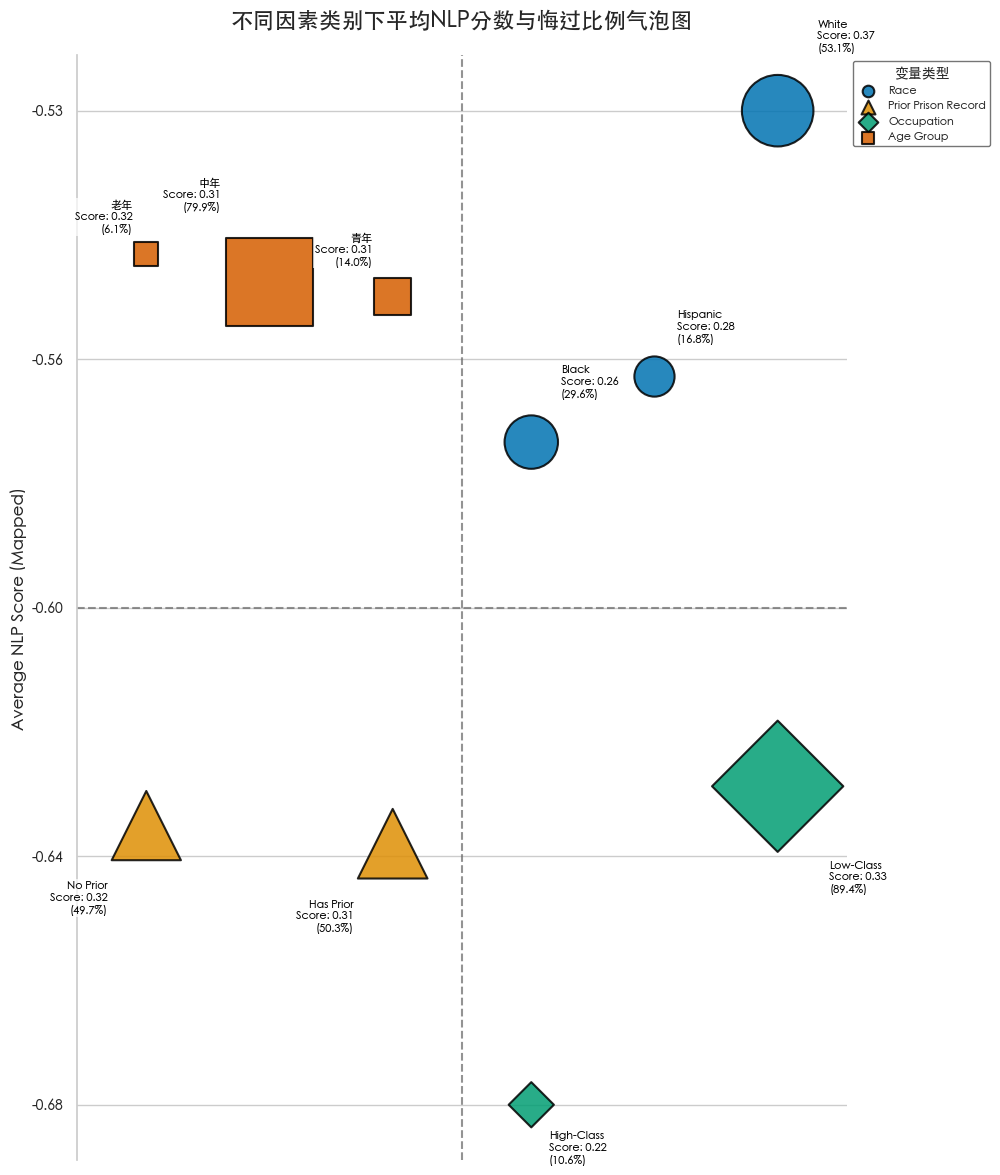


Data points for Bubble Chart (including Avg NLP Score):
         Variable_Type Category_Label  Proportion  Avg_NLP_Score  bubble_size  \
0                 Race          Black    0.296089       0.257282  1480.446927   
1                 Race       Hispanic    0.167598       0.280374   837.988827   
2                 Race          White    0.530726       0.374016  2653.631285   
3  Prior Prison Record       No Prior    0.497207       0.316726  2486.033520   
4  Prior Prison Record      Has Prior    0.502793       0.310345  2513.966480   
5           Occupation      Low-Class    0.893855       0.330579  4469.273743   
6           Occupation     High-Class    0.106145       0.218391   530.726257   
7            Age Group             青年    0.139665       0.308642   698.324022   
8            Age Group             中年    0.798883       0.313596  3994.413408   
9            Age Group             老年    0.061453       0.323529   307.262570   

      x         y  
0  0.18  0.299920  
1  0.50  0.

In [56]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd

# 设置中文字体和负号显示
plt.rcParams['font.family'] = 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False

# [Previous data preparation code remains unchanged until bubble plotting]

# --- 5. 绘制气泡图 ---
plt.figure(figsize=(12, 12))
ax = plt.gca()

# 使用比例来设置气泡大小
max_proportion = bubble_df['Proportion'].max() if not bubble_df.empty else 0
size_scale_factor = 8000 if max_proportion < 0.05 else 5000
bubble_df['bubble_size'] = bubble_df['Proportion'] * size_scale_factor

# 为不同变量类型定义不同的标记形状
markers = {
    'Race': 'o',           # 圆形
    'Age Group': 's',      # 方形
    'Prior Prison Record': '^',  # 三角形
    'Occupation': 'D'      # 菱形
}

# 绘制气泡
if not bubble_df.empty:
    for var_type, group in bubble_df.groupby('Variable_Type'):
        ax.scatter(
            group['x'],
            group['y'],
            s=group['bubble_size'],
            color=group['Color'].iloc[0],
            alpha=0.85,  # 增加不透明度
            edgecolors='black',  # 黑色边缘
            linewidth=1.5,  # 增加边缘宽度
            marker=markers[var_type],  # 使用不同的标记形状
            label=var_type
        )

        # 添加类别标签和平均NLP分数到气泡旁边
        for index, row in group.iterrows():
            label_offset = np.sqrt(row['bubble_size']) * 0.002  # 增加偏移量
            ha = 'left' if row['x'] > 0 else 'right'
            va = 'bottom' if row['y'] > 0 else 'top'

            x_text = row['x'] + (label_offset if row['x'] > 0 else -label_offset)
            y_text = row['y'] + (label_offset if row['y'] > 0 else -label_offset)

            ax.text(
                x_text,
                y_text,
                f"{row['Category_Label']}\nScore: {row['Avg_NLP_Score']:.2f}\n({row['Proportion']:.1%})",
                fontsize=8,
                ha=ha,
                va=va,
                color='black',
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)  # 添加白色背景
            )

# --- 6. 设置图表样式 ---
ax.set_title('不同因素类别下平均NLP分数与悔过比例气泡图', fontsize=16, fontweight='bold', pad=20)
ax.set_xlabel('')
ax.set_ylabel('Average NLP Score (Mapped)', fontsize=12, fontweight='bold')

# 隐藏 X 轴刻度标签
ax.set_xticks([])

# Y 轴刻度设置
y_tick_values_mapped = np.linspace(-0.9, 0.9, 5)
if nlp_range > 0:
    y_tick_labels_original = [(-0.9 + (y_map + 0.9) / 1.8 * nlp_range) + min_nlp for y_map in y_tick_values_mapped]
else:
    y_tick_labels_original = [min_nlp] * len(y_tick_values_mapped)
ax.set_yticks(y_tick_values_mapped)
ax.set_yticklabels([f'{val:.2f}' for val in y_tick_labels_original], fontsize=10)

# 绘制象限分隔线
ax.axhline(0, color='#666666', linewidth=1.5, linestyle='--', alpha=0.7)
ax.axvline(0, color='#666666', linewidth=1.5, linestyle='--', alpha=0.7)

# 设置轴范围
ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)

# 移除轴边框
sns.despine(ax=ax, left=False, bottom=True)

# 添加图例
handles, labels = ax.get_legend_handles_labels()
ordered_handles_labels = sorted(zip(labels, handles), 
                              key=lambda pair: list(variable_types).index(pair[0]) 
                              if pair[0] in variable_types else len(variable_types))
ordered_labels, ordered_handles = zip(*ordered_handles_labels)

# 自定义图例
legend = ax.legend(
    ordered_handles, 
    ordered_labels,
    title='变量类型',
    loc='upper left',
    bbox_to_anchor=(1, 1),
    frameon=True,
    markerscale=0.2,  # 将markerscale从0.7减小到0.5
    title_fontsize=10,  # 将title_fontsize从12减小到10
    fontsize=8,  # 将fontsize从10减小到8
    edgecolor='#666666',
    framealpha=0.9
)

# 调整布局
plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('../visualize/bubble_chart.png', dpi=600, bbox_inches='tight')
# 显示图表
plt.show()

# 打印计算结果
print("\nData points for Bubble Chart (including Avg NLP Score):")
print(bubble_df[['Variable_Type', 'Category_Label', 'Proportion', 'Avg_NLP_Score', 'bubble_size', 'x', 'y']])

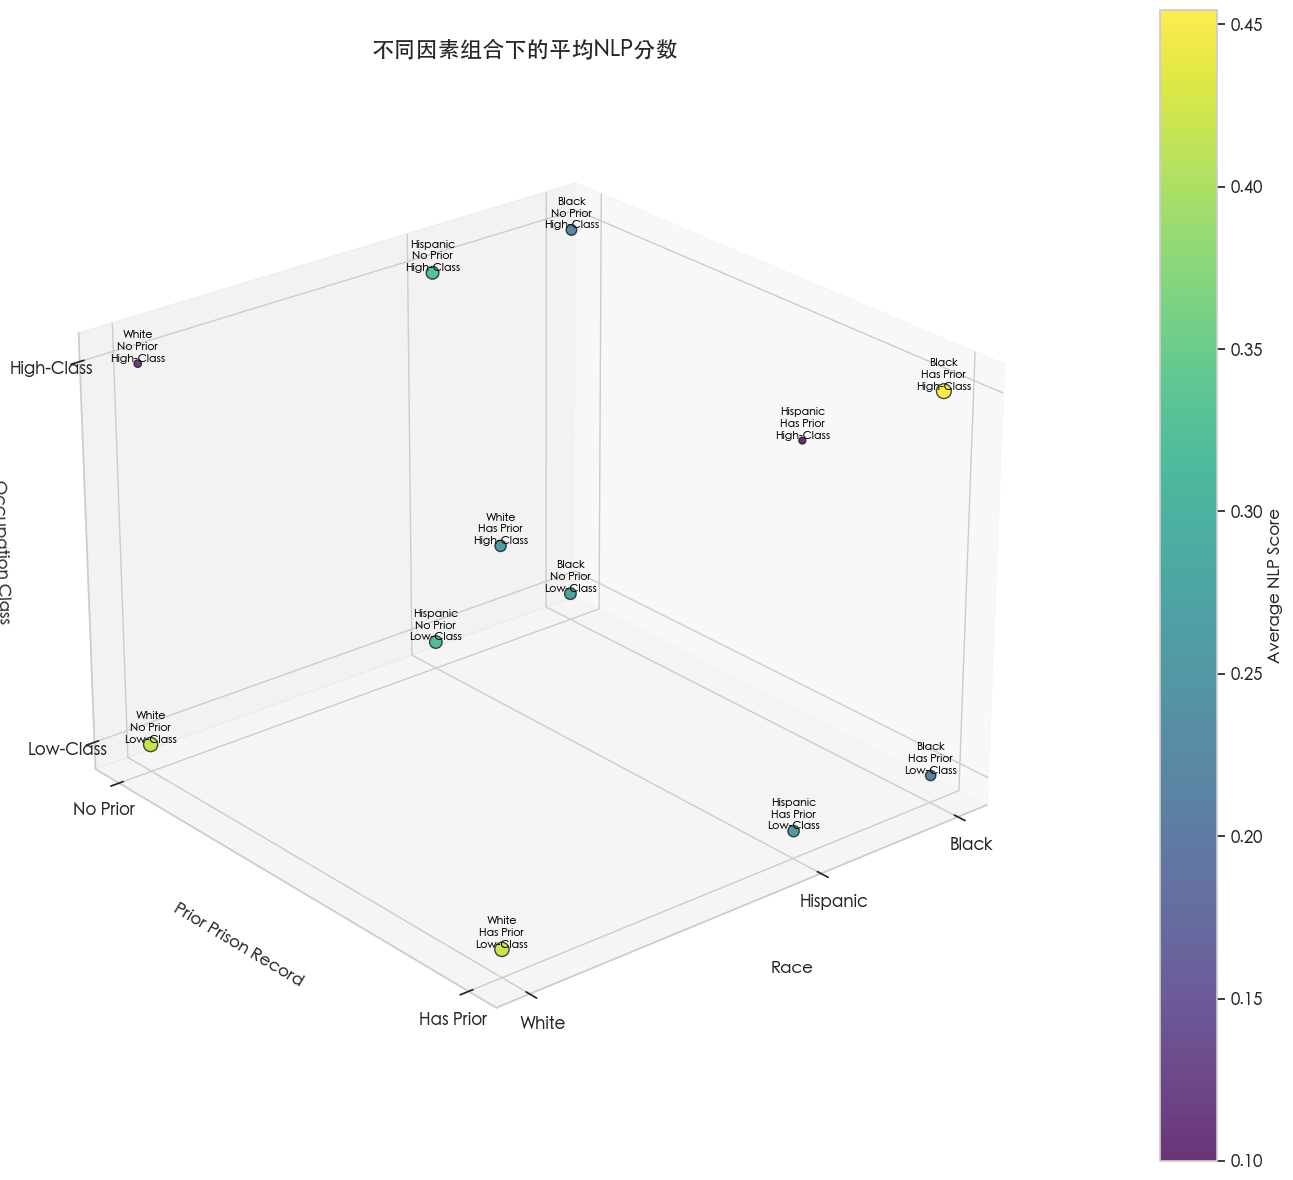


不同 race, prior prison record, occupation 组合下的平均 NLP 分数:
    race  Prior_Prison_Record  Occupation_Encoded  nlp_score
0      0                    0                   0   0.277778
1      0                    0                   1   0.230769
2      0                    1                   0   0.217391
3      0                    1                   1   0.454545
4      1                    0                   0   0.326531
5      1                    0                   1   0.333333
6      1                    1                   0   0.266667
7      1                    1                   1   0.100000
8      3                    0                   0   0.418367
9      3                    0                   1   0.115385
10     3                    1                   0   0.420561
11     3                    1                   1   0.260870


In [34]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# 设置中文字体
plt.rcParams['font.family'] = 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False

# 假设 dt DataFrame 包含 'race', 'prior prison record(0/1)', 'occupation_encoded', 'nlp_score' 列
# 并且 'prior prison record(0/1)' 和 'occupation_encoded' 已经处理好缺失值并编码为 0/1
# Race 编码为 0, 1, 3 （根据之前的分析）

# --- 数据计算 ---
# 过滤掉 Race 不在 [0, 1, 3] 的数据
# 过滤掉 prior prison record(0/1) 不在 [0, 1] 或缺失的数据
# 过滤掉 occupation_encoded 不在 [0, 1] 或缺失的数据
filtered_dt = dt[
    dt['race'].isin([0, 1, 3]) &
    dt['prior prison record(0/1)'].isin([0, 1]).fillna(False) & # 确保只包含 0/1 且非缺失
    dt['occupation_encoded'].isin([0, 1]).fillna(False)     # 确保只包含 0/1 且非缺失
].copy() # 使用 .copy() 避免SettingWithCopyWarning

# 按这三个维度分组并计算平均 nlp_score
grouped_nlp_scores = filtered_dt.groupby(
    ['race', 'prior prison record(0/1)', 'occupation_encoded']
)['nlp_score'].mean().reset_index() # reset_index() 将分组键变为列

# 重命名列方便理解
grouped_nlp_scores.rename(columns={
    'prior prison record(0/1)': 'Prior_Prison_Record',
    'occupation_encoded': 'Occupation_Encoded'
}, inplace=True)


# --- 准备绘图数据 ---
# X轴: Race (0, 1, 3)
# Y轴: Prior Prison Record (0, 1)
# Z轴: Occupation Encoded (0, 1)
# 颜色/大小: 平均 NLP Score

x_coords = grouped_nlp_scores['race']
y_coords = grouped_nlp_scores['Prior_Prison_Record']
z_coords = grouped_nlp_scores['Occupation_Encoded']
avg_nlp_scores = grouped_nlp_scores['nlp_score']

# 为了在三维图中标注分类变量，可以手动映射刻度标签
race_labels_map = {0: 'Black', 1: 'Hispanic', 3: 'White'}
prior_labels_map = {0: 'No Prior', 1: 'Has Prior'}
occupation_labels_map = {0: 'Low-Class', 1: 'High-Class'}

# --- 绘制三维图 ---
fig = plt.figure(figsize=(14, 12)) # 增大图尺寸以便容纳标签
ax = fig.add_subplot(111, projection='3d')

# 使用平均 NLP 分数来控制点的大小和颜色
# 点的大小可以与分数成正比
point_size = avg_nlp_scores * 250 # 适当增大点的大小
# 点的颜色可以使用一个颜色图，映射分数
scatter = ax.scatter(
    x_coords,
    y_coords,
    z_coords,
    c=avg_nlp_scores,
    cmap='viridis',
    s=point_size,
    alpha=0.8,
    edgecolors='k' # 添加边缘线增加区分度
)

# --- 添加文本标注 ---
for index, row in grouped_nlp_scores.iterrows():
    race_code = row['race']
    prior_code = row['Prior_Prison_Record']
    occupation_code = row['Occupation_Encoded']
    score = row['nlp_score']

    # 获取对应的文本标签
    race_label = race_labels_map.get(race_code, f'Race {race_code}')
    prior_label = prior_labels_map.get(prior_code, f'Prior {prior_code}')
    occupation_label = occupation_labels_map.get(occupation_code, f'Occ {occupation_code}')

    # 创建标注文本字符串
    # 可以选择显示分数或组合信息
    # label_text = f'{race_label}\n{prior_label}\n{occupation_label}\n({score:.2f})'
    label_text = f'{race_label}\n{prior_label}\n{occupation_label}' # 只显示类别组合

    # 添加文本到点的位置
    ax.text(
        race_code,
        prior_code,
        occupation_code,
        label_text,
        fontsize=8,  # 调整字体大小
        ha='center', # 水平居中
        va='bottom', # 垂直底部对齐
        color='black' # 标签颜色
    )


# 设置轴标签
ax.set_xlabel('Race', labelpad=15, fontsize=12) # 增加labelpad避免重叠
ax.set_ylabel('Prior Prison Record', labelpad=15, fontsize=12)
ax.set_zlabel('Occupation Class', labelpad=15, fontsize=12)
ax.set_title('不同因素组合下的平均NLP分数', fontsize=16, fontweight='bold', pad=20)

# 设置分类轴的刻度标签
ax.set_xticks(list(race_labels_map.keys()))
ax.set_xticklabels(list(race_labels_map.values()))

ax.set_yticks(list(prior_labels_map.keys()))
ax.set_yticklabels(list(prior_labels_map.values()))

ax.set_zticks(list(occupation_labels_map.keys()))
ax.set_zticklabels(list(occupation_labels_map.values()))

# 添加颜色条
cbar = fig.colorbar(scatter, ax=ax, pad=0.1)
cbar.set_label('Average NLP Score', fontsize=12)

# 调整视角 (可选)
ax.view_init(elev=25, azim=50) # 尝试一个更好的默认视角
plt.savefig('../visualize/3threedimension.png', dpi=600, bbox_inches='tight') # 保存图像
plt.tight_layout()

plt.show()

# 打印计算结果
print("\n不同 race, prior prison record, occupation 组合下的平均 NLP 分数:")
print(grouped_nlp_scores)

/var/folders/0m/2sbyxxc10czg8dp3clzyzxym0000gn/T/ipykernel_95818/2733855648.py:218: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout() # tight_layout 在 3D 图中可能行为不太稳定，必要时需要手动调整


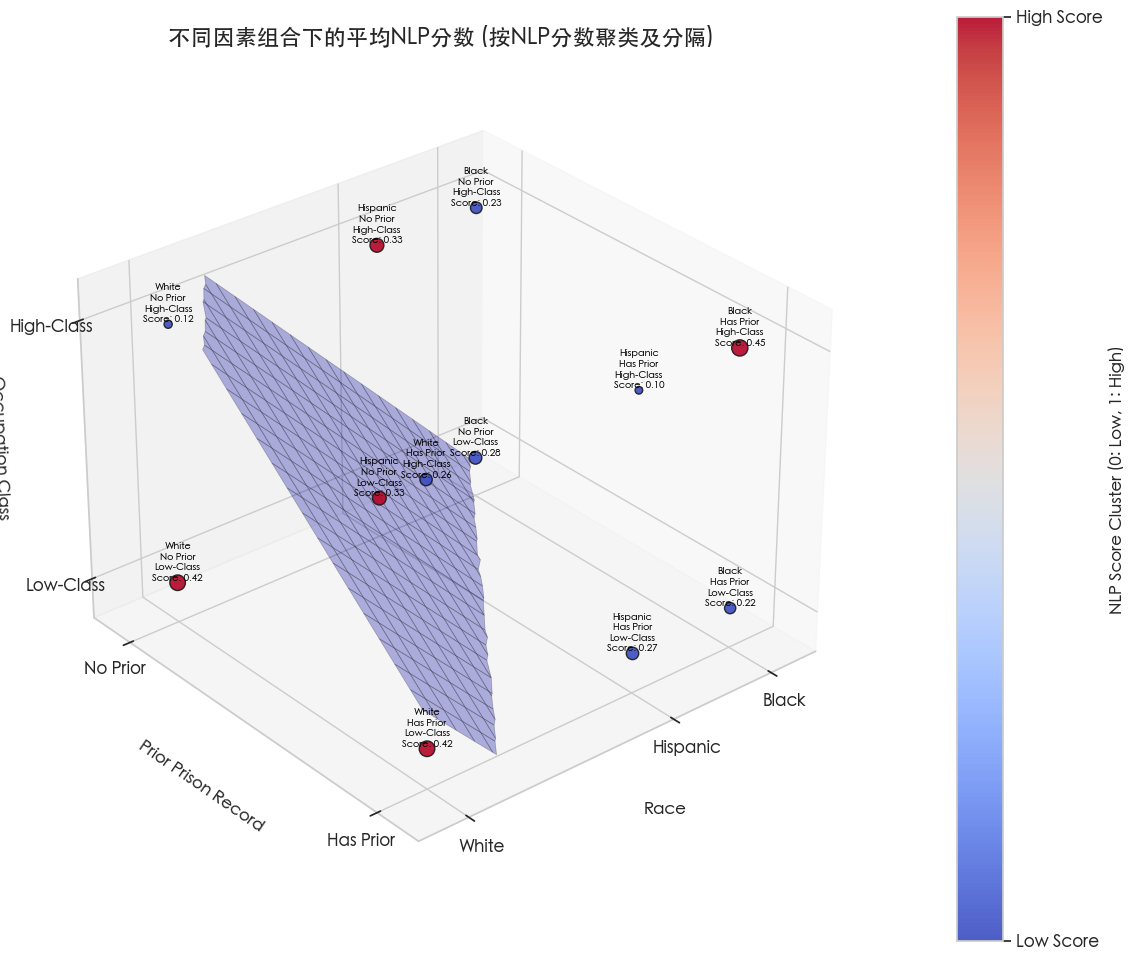


不同 race, prior prison record, occupation 组合下的平均 NLP 分数和聚类结果:
    race  Prior_Prison_Record  Occupation_Encoded  nlp_score  nlp_cluster
0      0                    0                   0   0.277778            0
1      0                    0                   1   0.230769            0
2      0                    1                   0   0.217391            0
3      0                    1                   1   0.454545            1
4      1                    0                   0   0.326531            1
5      1                    0                   1   0.333333            1
6      1                    1                   0   0.266667            0
7      1                    1                   1   0.100000            0
8      3                    0                   0   0.418367            1
9      3                    0                   1   0.115385            0
10     3                    1                   0   0.420561            1
11     3                    1                   1 

In [51]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler # 导入 StandardScaler

# 设置中文字体
plt.rcParams['font.family'] = 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False

# 假设 dt DataFrame 包含 'race', 'prior prison record(0/1)', 'occupation_encoded', 'nlp_score' 列
# 并且 'prior prison record(0/1)' 和 'occupation_encoded' 已经处理好缺失值并编码为 0/1
# Race 编码为 0, 1, 3 （根据之前的分析）

# --- 数据计算 ---
# 过滤掉 Race 不在 [0, 1, 3] 的数据
# 过滤掉 prior prison record(0/1) 不在 [0, 1] 或缺失的数据
# 过滤掉 occupation_encoded 不在 [0, 1] 或缺失的数据
filtered_dt = dt[
    dt['race'].isin([0, 1, 3]) &
    dt['prior prison record(0/1)'].isin([0, 1]).fillna(False) &
    dt['occupation_encoded'].isin([0, 1]).fillna(False)
].copy()

# 按这三个维度分组并计算平均 nlp_score
grouped_nlp_scores = filtered_dt.groupby(
    ['race', 'prior prison record(0/1)', 'occupation_encoded']
)['nlp_score'].mean().reset_index()

# 重命名列方便理解
grouped_nlp_scores.rename(columns={
    'prior prison record(0/1)': 'Prior_Prison_Record',
    'occupation_encoded': 'Occupation_Encoded'
}, inplace=True)


# --- 聚类平均 NLP 分数 ---
# 使用 K-Means 将平均 nlp_score 分为两类 (高分/低分)
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
grouped_nlp_scores['nlp_cluster'] = kmeans.fit_predict(grouped_nlp_scores[['nlp_score']])

# 根据聚类中心判断哪个是低分簇 (中心值较小的那个)
low_score_cluster_label = kmeans.cluster_centers_.argmin()
grouped_nlp_scores['nlp_cluster'] = grouped_nlp_scores['nlp_cluster'].apply(
    lambda x: 0 if x == low_score_cluster_label else 1 # 将低分簇设为0，高分簇设为1
)

# --- 准备绘图数据 ---
x_coords = grouped_nlp_scores['race']
y_coords = grouped_nlp_scores['Prior_Prison_Record']
z_coords = grouped_nlp_scores['Occupation_Encoded']
avg_nlp_scores = grouped_nlp_scores['nlp_score']
cluster_labels = grouped_nlp_scores['nlp_cluster']

# 为了在三维图中标注分类变量，可以手动映射刻度标签
race_labels_map = {0: 'Black', 1: 'Hispanic', 3: 'White'}
prior_labels_map = {0: 'No Prior', 1: 'Has Prior'}
occupation_labels_map = {0: 'Low-Class', 1: 'High-Class'}

# --- 使用线性 SVM 寻找分隔平面 ---
# 使用 (race, prior_record, occupation) 作为特征，聚类标签作为目标
X_features = grouped_nlp_scores[['race', 'Prior_Prison_Record', 'Occupation_Encoded']].values
y_labels = cluster_labels.values

# # 可选：对特征进行标准化，有时有助于 LinearSVC 找到更好的边界
# scaler = StandardScaler()
# X_features_scaled = scaler.fit_transform(X_features)

# 训练线性 SVM 分类器
# 尝试更大的 C 值，鼓励模型严格分隔训练点
# 增加 max_iter 以防不收敛
svm_plane = LinearSVC(random_state=42, max_iter=10000, C=10.0) # 增大 C 值

coef = None # 初始化 coef 和 intercept 为 None
intercept = None

try:
    # svm_plane.fit(X_features_scaled, y_labels) # 如果使用了标准化
    svm_plane.fit(X_features, y_labels) # 使用原始特征

    # 获取平面参数 Ax + By + Cz + D = 0
    coef = svm_plane.coef_[0]
    intercept = svm_plane.intercept_[0]

    # # 如果使用了标准化，需要逆转标准化以在原始特征空间绘制平面
    # # 这是一个复杂的过程，通常直接用非标准化特征训练 LinearSVC 更方便可视化
    # # 如果 coef 接近 0，直接绘制平面可能会有问题，需要处理这种情况
    # if np.allclose(coef, 0):
    #     print("Warning: Coefficients are all close to zero, plane is not well-defined.")
    #     coef = None # Mark as failed to find a valid plane

except Exception as e:
    print(f"Warning: Could not train LinearSVC to find separating plane. Error: {e}")
    coef = None # Mark as failed to find a plane


# --- 绘制三维图 ---
fig = plt.figure(figsize=(14, 12)) # 增大图尺寸以便容纳标签
ax = fig.add_subplot(111, projection='3d')

# 使用聚类标签作为颜色，区分高/低NLP簇
# 'coolwarm' 颜色图，通常 0 (低值) 对应 'cool' (蓝色系), 1 (高值) 对应 'warm' (红色系)
scatter = ax.scatter(
    x_coords,
    y_coords,
    z_coords,
    c=cluster_labels,
    cmap='coolwarm',
    s=avg_nlp_scores * 300, # 点大小仍反映平均分数，适当调大
    alpha=0.9, # 提高透明度
    edgecolors='k'
)

# --- 添加文本标注 ---
for index, row in grouped_nlp_scores.iterrows():
    race_code = row['race']
    prior_code = row['Prior_Prison_Record']
    occupation_code = row['Occupation_Encoded']
    score = row['nlp_score']
    cluster = row['nlp_cluster']

    # 获取对应的文本标签
    race_label = race_labels_map.get(race_code, f'Race {race_code}')
    prior_label = prior_labels_map.get(prior_code, f'Prior {prior_code}')
    occupation_label = occupation_labels_map.get(occupation_code, f'Occ {occupation_code}')

    # 创建标注文本字符串
    label_text = f'{race_label}\n{prior_label}\n{occupation_label}\nScore: {score:.2f}' # 显示类别组合和分数

    # 添加文本到点的位置
    # 可能需要微调位置以避免与点重叠
    ax.text(
        race_code,
        prior_code,
        occupation_code,
        label_text,
        fontsize=7,
        ha='center',
        va='bottom',
        color='black'
    )

# --- 绘制分隔平面 (如果成功找到且 coef[2] 不接近 0) ---
# 检查 coef 是否存在且 Z 轴系数是否不接近零
if coef is not None and abs(coef[2]) > 1e-6:
    # 创建网格
    # 使用轴的实际范围创建网格
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    x_surf, y_surf = np.meshgrid(np.linspace(xlim[0], xlim[1], 100),
                                 np.linspace(ylim[0], ylim[1], 100))

    # 计算对应的 z 值
    # 平面方程: coef[0]*x + coef[1]*y + coef[2]*z + intercept = 0
    # 解出 z = (-coef[0]*x - coef[1]*y - intercept) / coef[2]
    z_surf = (-coef[0] * x_surf - coef[1] * y_surf - intercept) / coef[2]

    # 过滤掉超出 Z 轴范围的平面部分，使图更清晰 (可选)
    zlim = ax.get_zlim()
    z_surf[(z_surf < zlim[0]) | (z_surf > zlim[1])] = np.nan


    # 绘制半透明平面，添加网格线
    ax.plot_surface(
        x_surf, y_surf, z_surf,
        color='blue', # 可以选择一个中性或能区分两类的颜色
        alpha=0.3, # 调整透明度
        rstride=5,
        cstride=5,
        linewidth=0.5,
        edgecolor='k', # 网格线颜色
        antialiased=True
    )

# elif coef is not None:
#     # 如果 coef[2] 接近零，平面可能垂直于XY平面，需要根据 coef[0] 或 coef[1] 来解
#     # 这里为了简洁，省略了 coef[0] 或 coef[1] 接近零的情况
#     print("Warning: Coefficient for Z-axis is close to zero, plane visualization might be inaccurate or omitted.")


# 设置轴标签
ax.set_xlabel('Race', labelpad=15, fontsize=12)
ax.set_ylabel('Prior Prison Record', labelpad=15, fontsize=12)
ax.set_zlabel('Occupation Class', labelpad=15, fontsize=12)
ax.set_title('不同因素组合下的平均NLP分数 (按NLP分数聚类及分隔)', fontsize=16, fontweight='bold', pad=20) # 更新标题

# 设置分类轴的刻度标签
ax.set_xticks(list(race_labels_map.keys()))
ax.set_xticklabels(list(race_labels_map.values()))

ax.set_yticks(list(prior_labels_map.keys()))
ax.set_yticklabels(list(prior_labels_map.values()))

ax.set_zticks(list(occupation_labels_map.keys()))
ax.set_zticklabels(list(occupation_labels_map.values()))

# 调整轴的范围以包含刻度标签 (可能需要手动调整或让matplotlib自动处理)
# ax.set_xlim([min(list(race_labels_map.keys()))-0.5, max(list(race_labels_map.keys()))+0.5])
# ax.set_ylim([min(list(prior_labels_map.keys()))-0.5, max(list(prior_labels_map.keys()))+0.5])
# ax.set_zlim([min(list(occupation_labels_map.keys()))-0.5, max(list(occupation_labels_map.keys()))+0.5])


# 添加颜色条 (解释聚类颜色)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, ticks=[0, 1])
cbar.set_label('NLP Score Cluster (0: Low, 1: High)', fontsize=12)
cbar.set_ticklabels(['Low Score', 'High Score']) # 设置刻度标签

# 调整视角以获得更好的观察角度
ax.view_init(elev=30, azim=50) # 尝试不同的仰角和方位角

# 添加网格线 (matplotlib 3D 默认可能有网格)
# ax.grid(True, linestyle='--', alpha=0.3)

# 自动调整布局并显示
plt.tight_layout() # tight_layout 在 3D 图中可能行为不太稳定，必要时需要手动调整
plt.savefig('../visualize/threedimension.png', dpi=600, bbox_inches='tight') # 保存图像
plt.show()

# 打印计算结果和聚类结果
print("\n不同 race, prior prison record, occupation 组合下的平均 NLP 分数和聚类结果:")
print(grouped_nlp_scores)
if coef is not None:
    print(f"\n分隔平面方程 (Ax + By + Cz + D = 0):")
    print(f"A = {coef[0]:.4f}, B = {coef[1]:.4f}, C = {coef[2]:.4f}, D = {intercept:.4f}")
else:
    print("\n未能找到分隔平面。")

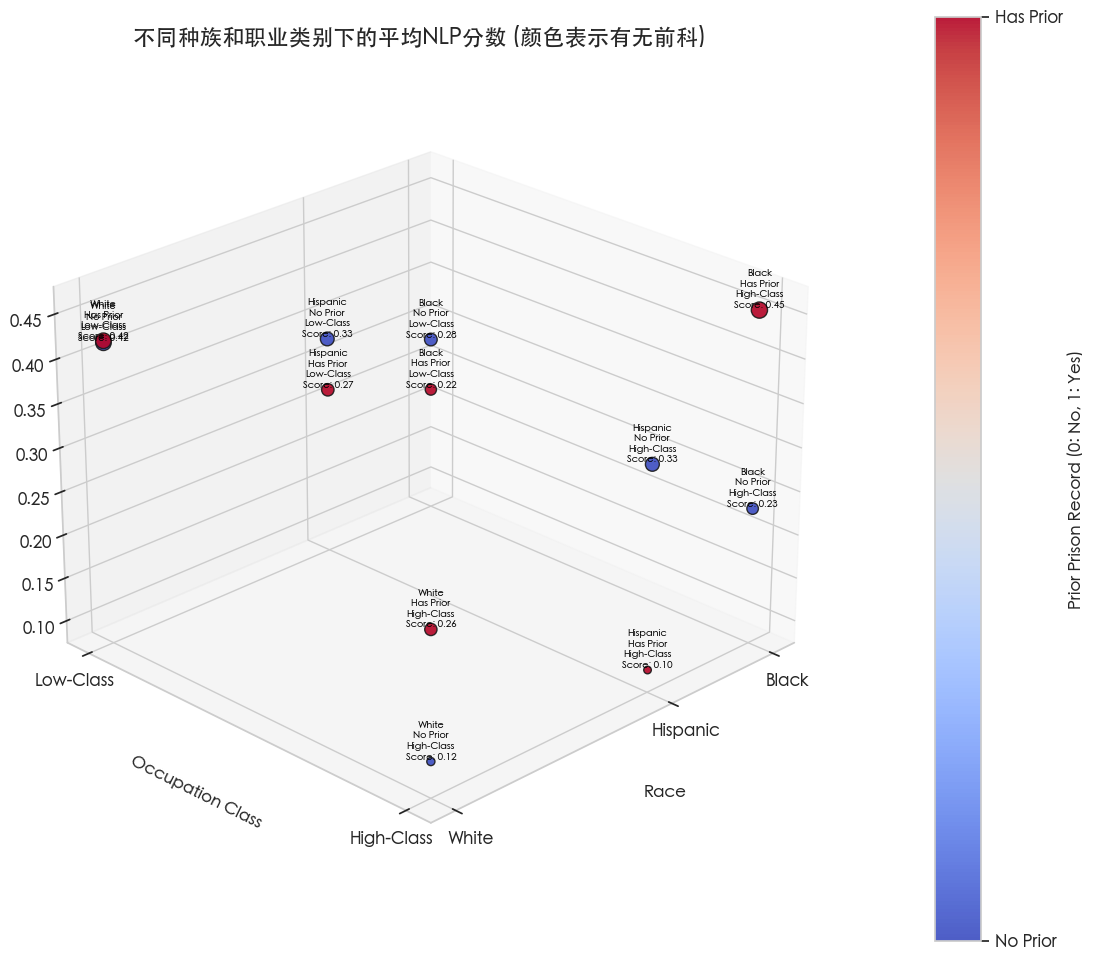


不同 race, prior prison record, occupation 组合下的平均 NLP 分数:
    race  Prior_Prison_Record  Occupation_Encoded  nlp_score
0      0                    0                   0   0.277778
1      0                    0                   1   0.230769
2      0                    1                   0   0.217391
3      0                    1                   1   0.454545
4      1                    0                   0   0.326531
5      1                    0                   1   0.333333
6      1                    1                   0   0.266667
7      1                    1                   1   0.100000
8      3                    0                   0   0.418367
9      3                    0                   1   0.115385
10     3                    1                   0   0.420561
11     3                    1                   1   0.260870


In [36]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D

# 设置中文字体
plt.rcParams['font.family'] = 'Heiti TC'
plt.rcParams['axes.unicode_minus'] = False

# 假设 dt DataFrame 包含 'race', 'prior prison record(0/1)', 'occupation_encoded', 'nlp_score' 列
# 并且 'prior prison record(0/1)' 和 'occupation_encoded' 已经处理好缺失值并编码为 0/1
# Race 编码为 0, 1, 3 （根据之前的分析）

# --- 数据计算 (与之前相同) ---
# 过滤掉 Race 不在 [0, 1, 3] 的数据
# 过滤掉 prior prison record(0/1) 不在 [0, 1] 或缺失的数据
# 过滤掉 occupation_encoded 不在 [0, 1] 或缺失的数据
filtered_dt = dt[
    dt['race'].isin([0, 1, 3]) &
    dt['prior prison record(0/1)'].isin([0, 1]).fillna(False) &
    dt['occupation_encoded'].isin([0, 1]).fillna(False)
].copy()

# 按这三个维度分组并计算平均 nlp_score
grouped_nlp_scores = filtered_dt.groupby(
    ['race', 'prior prison record(0/1)', 'occupation_encoded']
)['nlp_score'].mean().reset_index()

# 重命名列方便理解
grouped_nlp_scores.rename(columns={
    'prior prison record(0/1)': 'Prior_Prison_Record',
    'occupation_encoded': 'Occupation_Encoded'
}, inplace=True)

# --- 准备绘图数据 (轴分配改变) ---
# X轴: Race (0, 1, 3)
# Y轴: Occupation Encoded (0, 1)
# Z轴: 平均 NLP Score
# 颜色: Prior Prison Record (0, 1)
# 大小: 平均 NLP Score

x_coords = grouped_nlp_scores['race']
y_coords = grouped_nlp_scores['Occupation_Encoded'] # Y轴现在是职业类别
z_coords = grouped_nlp_scores['nlp_score']         # Z轴现在是平均NLP分数
color_data = grouped_nlp_scores['Prior_Prison_Record'] # 颜色表示有无前科
size_data = grouped_nlp_scores['nlp_score'] * 300      # 点大小仍反映平均分数

# 为了在三维图中标注分类变量，可以手动映射刻度标签
race_labels_map = {0: 'Black', 1: 'Hispanic', 3: 'White'}
prior_labels_map = {0: 'No Prior', 1: 'Has Prior'}
occupation_labels_map = {0: 'Low-Class', 1: 'High-Class'}

# --- 绘制三维图 ---
fig = plt.figure(figsize=(14, 12)) # 增大图尺寸以便容纳标签
ax = fig.add_subplot(111, projection='3d')

# 使用 Prior_Prison_Record (0/1) 作为颜色
# 'coolwarm' 颜色图，通常 0 对应 cool (蓝色系), 1 对应 warm (红色系)
scatter = ax.scatter(
    x_coords,
    y_coords,
    z_coords,
    c=color_data,       # 使用 Prior_Prison_Record 作为颜色数据
    cmap='coolwarm',    # 使用 coolwarm 颜色图区分 0 和 1
    s=size_data,        # 点大小反映平均分数
    alpha=0.9,          # 提高透明度
    edgecolors='k'      # 添加边缘线增加区分度
)

# --- 添加文本标注 ---
for index, row in grouped_nlp_scores.iterrows():
    race_code = row['race']
    prior_code = row['Prior_Prison_Record']
    occupation_code = row['Occupation_Encoded']
    score = row['nlp_score']

    # 获取对应的文本标签
    race_label = race_labels_map.get(race_code, f'Race {race_code}')
    prior_label = prior_labels_map.get(prior_code, f'Prior {prior_code}')
    occupation_label = occupation_labels_map.get(occupation_code, f'Occ {occupation_code}')

    # 创建标注文本字符串
    # 标签现在显示所有三个分类信息和分数
    label_text = f'{race_label}\n{prior_label}\n{occupation_label}\nScore: {score:.2f}'

    # 添加文本到点的位置
    # 注意这里的坐标顺序要与 scatter 对应 (race, occupation, nlp_score)
    ax.text(
        race_code,
        occupation_code, # Y坐标是职业类别编码
        score,         # Z坐标是平均NLP分数
        label_text,
        fontsize=7,
        ha='center',
        va='bottom',
        color='black'
    )

# --- 设置轴标签 ---
# 轴标签反映新的轴分配
ax.set_xlabel('Race', labelpad=15, fontsize=12)
ax.set_ylabel('Occupation Class', labelpad=15, fontsize=12) # Y轴标签是职业类别
ax.set_zlabel('Average NLP Score', labelpad=15, fontsize=12) # Z轴标签是平均NLP分数
ax.set_title('不同种族和职业类别下的平均NLP分数 (颜色表示有无前科)', fontsize=16, fontweight='bold', pad=20) # 更新标题

# --- 设置分类轴的刻度标签 ---
# X轴是Race
ax.set_xticks(list(race_labels_map.keys()))
ax.set_xticklabels(list(race_labels_map.values()))

# Y轴是Occupation Class
ax.set_yticks(list(occupation_labels_map.keys()))
ax.set_yticklabels(list(occupation_labels_map.values()))

# Z轴是连续的NLP分数，不需要手动设置刻度标签，matplotlib会自动处理

# --- 添加颜色条 (解释有无前科的颜色) ---
# 颜色条现在代表 Prior_Prison_Record (0/1)
cbar = fig.colorbar(scatter, ax=ax, pad=0.1, ticks=[0, 1])
cbar.set_label('Prior Prison Record (0: No, 1: Yes)', fontsize=12) # 更新颜色条标签
cbar.set_ticklabels(['No Prior', 'Has Prior']) # 设置刻度标签

# --- 调整视角 (可选) ---
# 尝试不同的仰角 (elev) 和方位角 (azim) 来找到最佳观察角度
ax.view_init(elev=25, azim=45)

# 添加网格线 (matplotlib 3D 默认可能有网格)
# ax.grid(True, linestyle='--', alpha=0.3)

# 自动调整布局并显示
plt.show()

# 打印计算结果 (保持不变)
print("\n不同 race, prior prison record, occupation 组合下的平均 NLP 分数:")
print(grouped_nlp_scores)